# NSF Computer and Information Science and Engineering (CISE) 

- `05050000`: Division of Computer and Network Systems (CNS)
- `05010000`: Division of Computing and Communication Foundations (CCF)
- `05020000`: Division of Information and Intelligent Systems (IIS)
- `05090000`: Office of Advanced Cyberinfrastructure (OAC)

In [9]:
import os,sys,json
import core.coworknet, core.nsf_utils
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import networkx as nx
import seaborn as sns
import pandas as pd
from datetime import datetime
from collections import Counter

In [2]:
grant_type = ["Standard Grant", "Continuing grant"] # draw only these types
div_type = {
    "05050000": "Division of Computer and Network Systems (CNS)",
    "05010000": "Division of Computing and Communication Foundations (CCF)",
    "05020000": "Division of Information and Intelligent Systems (IIS)",
    "05090000": "Office of Advanced Cyberinfrastructure (OAC)"
}

In [3]:
def histogram_num_pis(data, years, orgcodes):
    plt.title("[NSF {}-{}] histogram - number of PIs".format(years[0], years[-1]))
    plt.ylabel("Number of grants")
    plt.xlabel("Number of PIs")
    pis = [d["num_pis"] for d in data.values() if d["org"] in orgcodes]
    counter_pis = Counter(pis)
    print(counter_pis)
    x = range(1, 10)
    y = [counter_pis[i] if i in counter_pis else 0 for i in x]
    plt.bar(x, y)

In [4]:
def plot_coauthor_heatmap(pid):
    table, ts, te, G = core.coworknet.get_grant_coworknet_pis(pid)
#     print(sorted(G.degree, key=lambda x: x[1], reverse=True))
    authors = list([a[0] for a in sorted(G.degree, key=lambda x: x[1], reverse=True)])

    if len(table) == 0:
#         print("No publication between PIs")
        no_publications.append(pid)
        return
    
    # calculate coauthorship by year
    times = range(min([v["year"] for v in table.values()]), 1+max([v["year"] for v in table.values()]))
    years = [datetime.strptime(str(t), "%Y") for t in times]
    dates = {y:[] for y in times}
    for v in table.values():
        dates[v["year"]].extend(v["authors"])
    dates_ingrant = {y:[] for y in times}
    for v in table.values():
        if v["type"]:
            dates_ingrant[v["year"]].extend(v["authors"])
    coauthored_ingrant = np.array([[dates_ingrant[t].count(a) for t in times] for a in authors])
    coauthored = np.array([[dates[t].count(a) for t in times] for a in authors])
    
    fig, ax = plt.subplots(figsize=(len(times)/2,len(authors)/2))
    im = ax.imshow(coauthored, cmap="YlGn")

    ax.set_xticks(np.arange(len(years)))
    ax.set_yticks(np.arange(len(authors)))
    # ax.set_xticklabels([datetime.strftime(t, "%Y-%m-%d") for t in times])
    ax.set_xticklabels(times)
    ax.set_yticklabels(authors)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    for i in range(len(authors)):
        for j in range(len(years)):
            label = str(coauthored[i, j] if coauthored[i, j] > 0 else "")
            if coauthored_ingrant[i, j] > 0:
                label = str(coauthored_ingrant[i, j]) + "/" + label
            if ts <= years[j] and years[j] <= te:
                text = ax.text(j, i, label, ha="center", va="center", color="black", fontweight="bold")
            else:
                text = ax.text(j, i, label, ha="center", va="center", color="black")

    ax.set_title("{} ({}~{})".format(pid, datetime.strftime(ts, "%Y-%m-%d"), datetime.strftime(te, "%Y-%m-%d")))
    plt.show()

def plot_coauthor_heatmap_paper(pid):
    table, ts, te, G = core.coworknet.get_grant_coworknet_pis(pid)
    authors = list([a[0] for a in sorted(G.degree, key=lambda x: x[1], reverse=True)])

    if len(table) == 0:
        no_publications.append(pid)
        return
    
    # calculate coauthorship by papar
    times = sorted([v["date"] for v in table.values()])
    dates = {v["date"]:v["authors"] for v in table.values()}
    dates_ingrant = [v["date"] for v in table.values() if v["type"]]
    coauthored = np.array([[2 if ts <= t and t <= te and a in dates[t] else (1 if a in dates[t] else 0) for t in times] for a in authors])
    coauthored_ingrant = np.array([[1 if t in dates_ingrant and a in dates[t] else 0 for t in times] for a in authors])
    
    fig, ax = plt.subplots(figsize=(len(times)/5,len(authors)/2))
    im = ax.imshow(coauthored, cmap="GnBu", vmin=0)

    ax.set_xticks(np.arange(len(times)))
    ax.set_yticks(np.arange(len(authors)))
    ax.set_xticklabels([datetime.strftime(t, "%Y-%m-%d") for t in times])
    ax.set_yticklabels(authors)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    for i in range(len(authors)):
        for j in range(len(times)):
            label = "*" if coauthored_ingrant[i, j] > 0 else ""
            text = ax.text(j, i, label, ha="center", va="center", color="black")

    ax.set_title("{} ({}~{})".format(pid, datetime.strftime(ts, "%Y-%m-%d"), datetime.strftime(te, "%Y-%m-%d")))
    plt.show()

In [5]:
data = {}
years = [2004]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"] == code and v["year"] == y]))

[2004]
Total number of grants 10212
Division of Computer and Network Systems (CNS) 405
Division of Computing and Communication Foundations (CCF) 332
Division of Information and Intelligent Systems (IIS) 362
Office of Advanced Cyberinfrastructure (OAC) 53


Counter({1: 633, 2: 243, 3: 123, 5: 83, 4: 61, 6: 4, 0: 2, 7: 2, 8: 1})


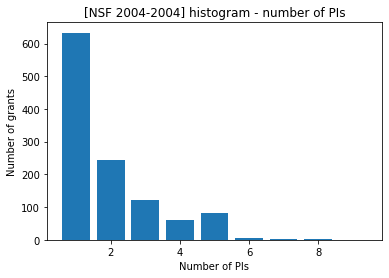

In [6]:
histogram_num_pis(data, years, div_type.keys())

In [31]:
grant_list = [k for k, d in data.items() if d["org"] in div_type.keys() and d["num_pis"] == 5]
print(grant_list)

['0403313', '0403340', '0403342', '0403428', '0403673', '0403760', '0403990', '0404208', '0406403', '0416128', '0420477', '0420614', '0420703', '0420793', '0420836', '0420933', '0420984', '0421063', '0421099', '0421109', '0421200', '0421282', '0421456', '0421502', '0421554', '0423336', '0423386', '0423431', '0423733', '0423891', '0424546', '0426125', '0426593', '0426683', '0426886', '0426971', '0426972', '0427005', '0427413', '0427794', '0428168', '0428216', '0428241', '0428249', '0428344', '0428404', '0428420', '0428472', '0428738', '0428856', '0428887', '0429086', '0429358', '0430175', '0430274', '0430444', '0430722', '0431070', '0432047', '0433540', '0433702', '0435061', '0435190', '0435297', '0435307', '0435353', '0435370', '0435389', '0435425', '0442156', '0444465', '0451843', '0453809', '0454066', '0454074', '0454114', '0454259', '0454279', '0454298', '0454333', '0454394', '0454404', '0454407']


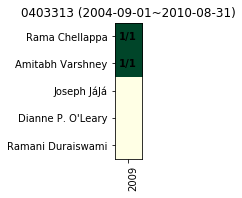

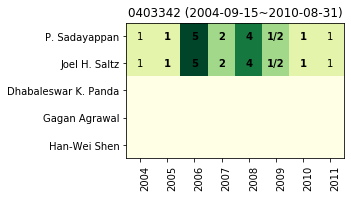

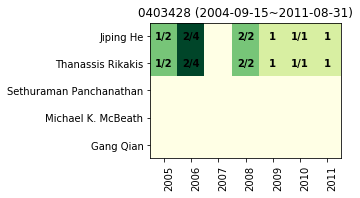

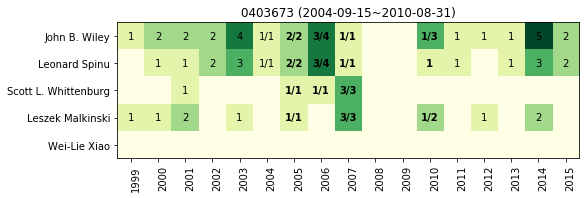

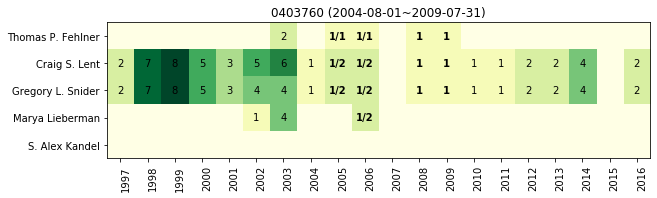

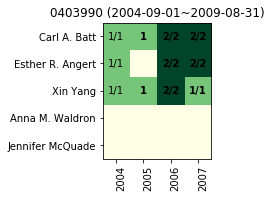

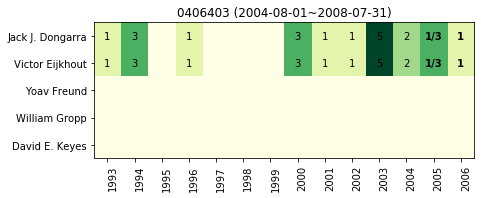

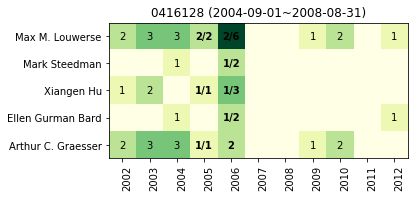

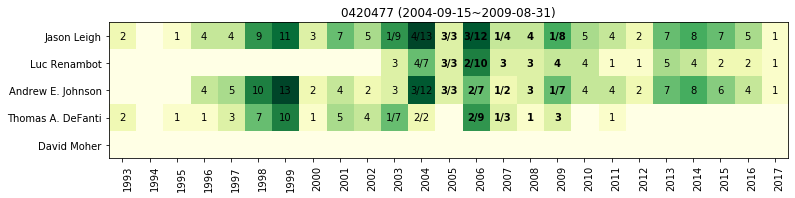

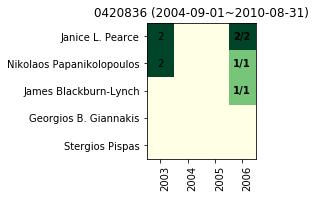

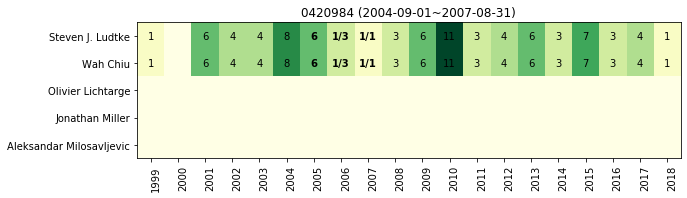

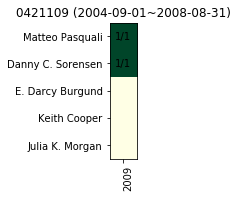

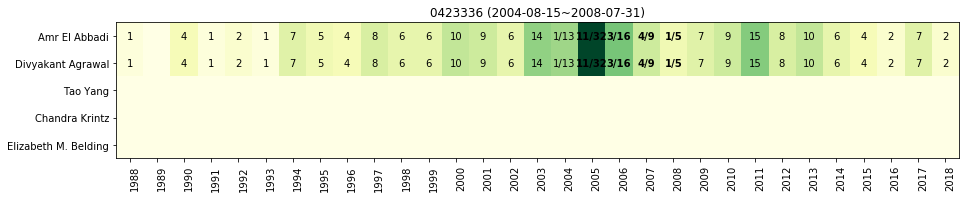

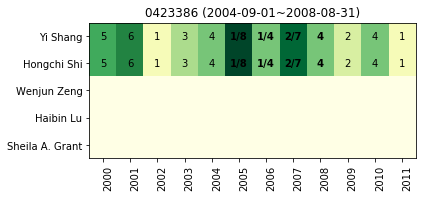

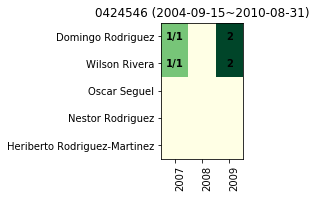

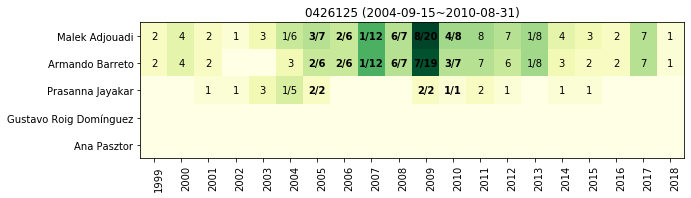

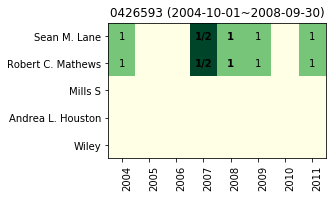

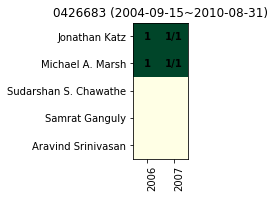

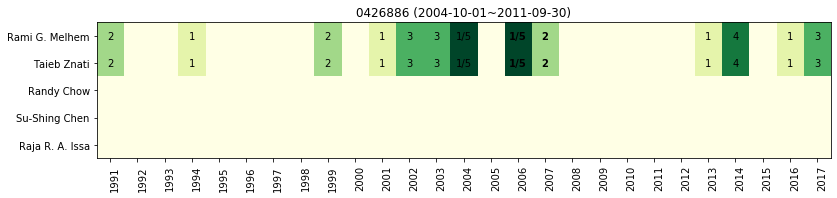

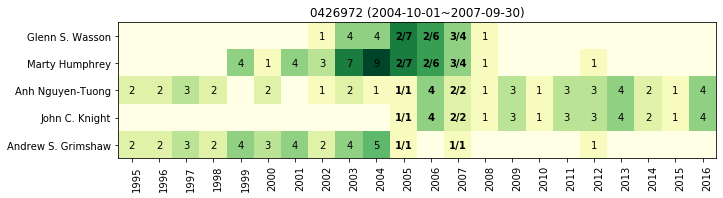

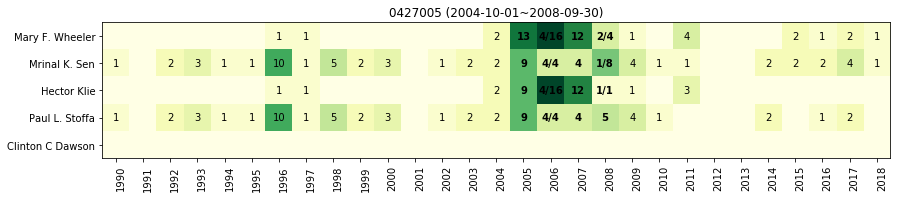

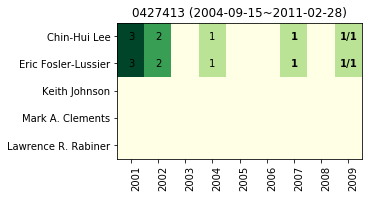

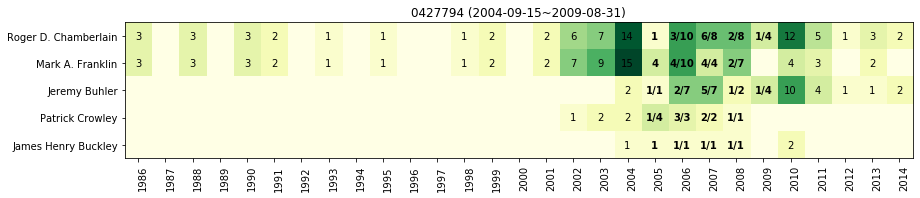

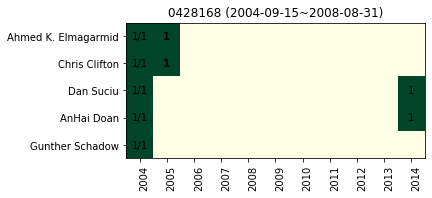

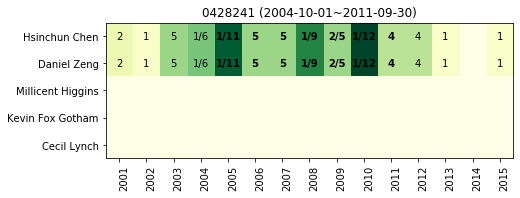

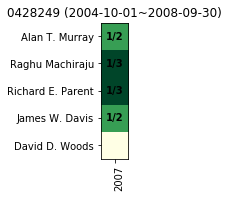

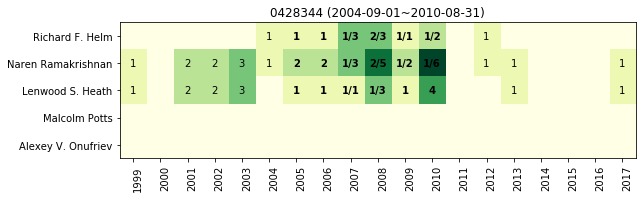

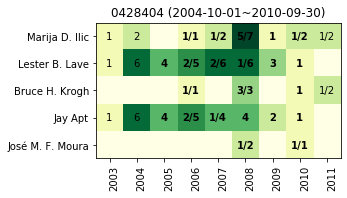

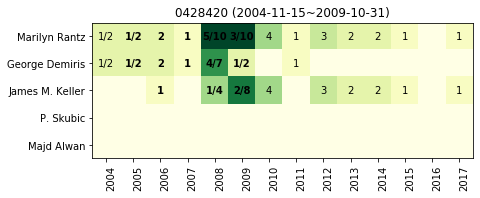

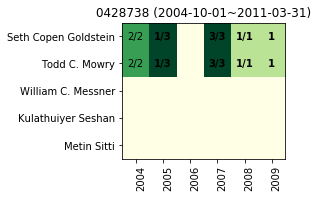

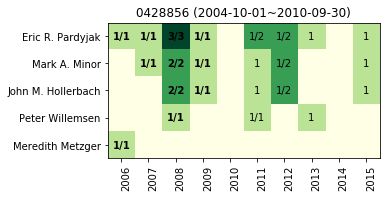

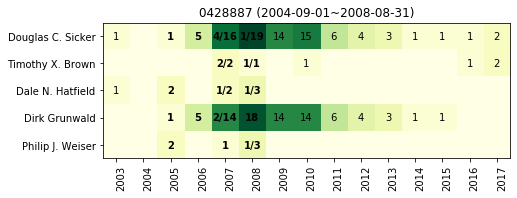

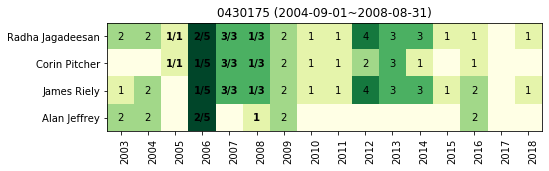

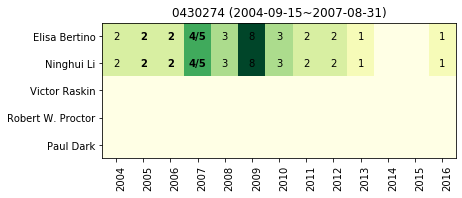

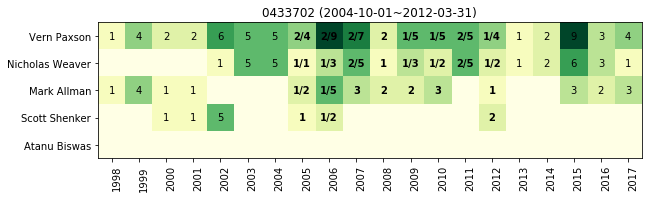

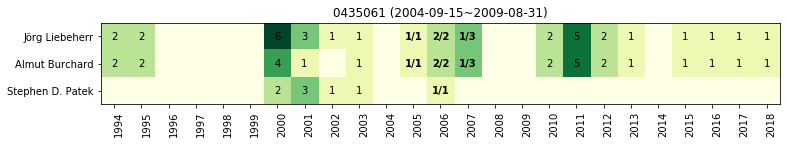

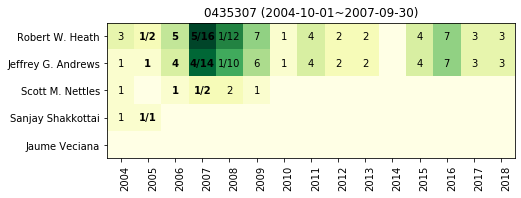

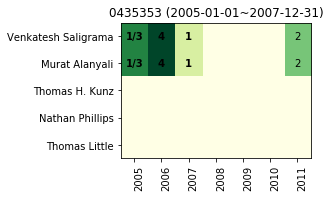

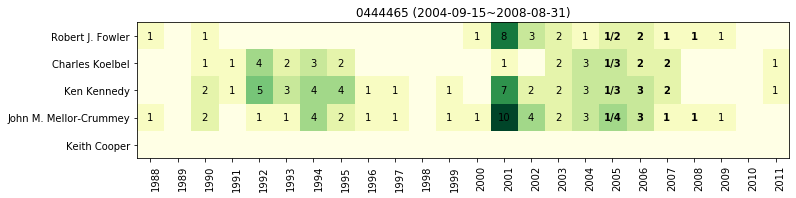

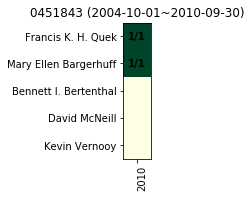

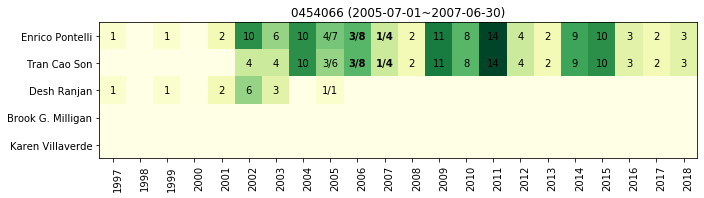

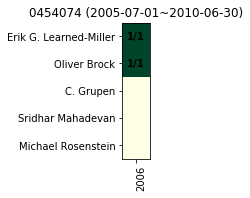

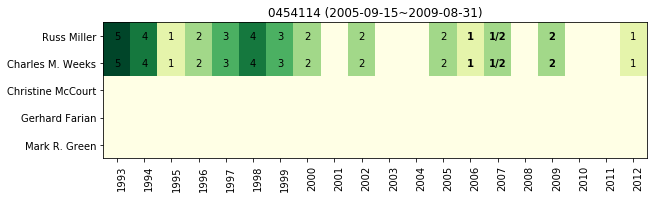

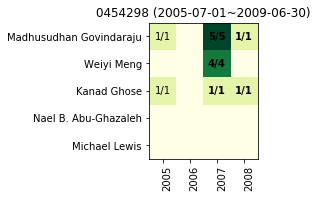

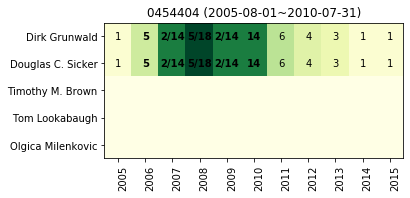

38 grants have no publication between PIs ['0403340', '0404208', '0420614', '0420703', '0420793', '0420933', '0421063', '0421099', '0421200', '0421282', '0421456', '0421502', '0421554', '0423431', '0423733', '0423891', '0426971', '0428216', '0428472', '0429086', '0429358', '0430444', '0430722', '0431070', '0432047', '0433540', '0435190', '0435297', '0435370', '0435389', '0435425', '0442156', '0453809', '0454259', '0454279', '0454333', '0454394', '0454407']


In [66]:
no_publications = []
for pid in grant_list:
    plot_coauthor_heatmap(pid)
print("{} grants have no publication between PIs".format(len(no_publications)), no_publications)

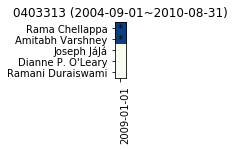

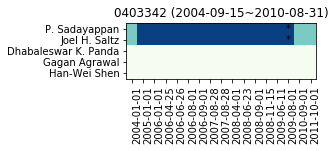

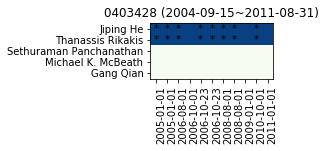

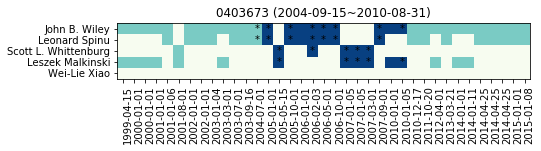

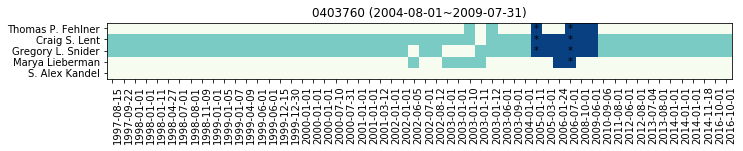

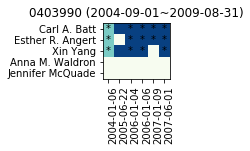

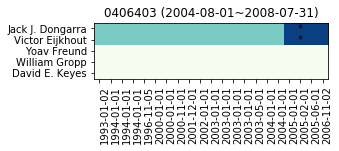

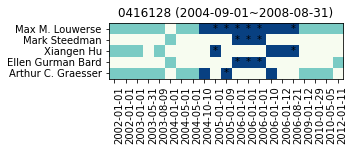

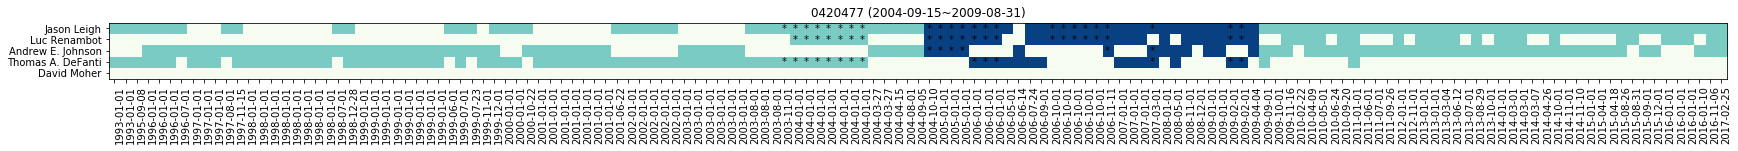

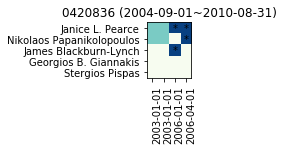

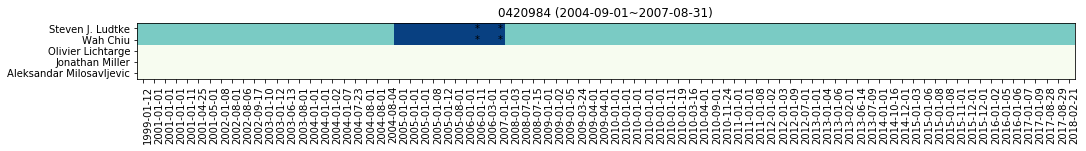

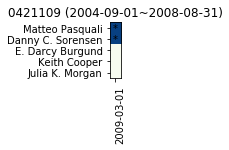

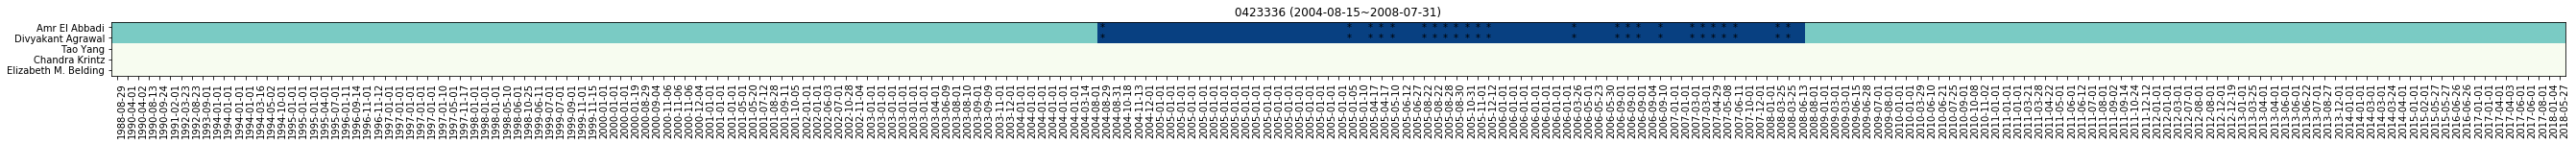

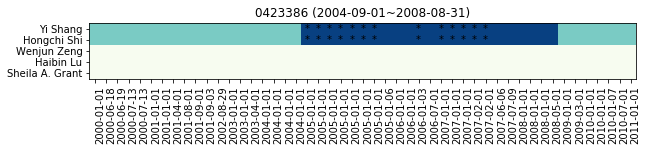

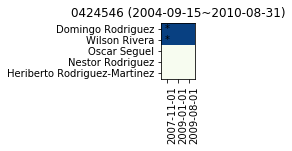

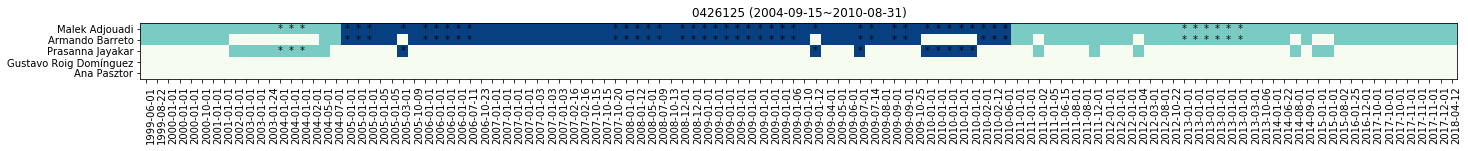

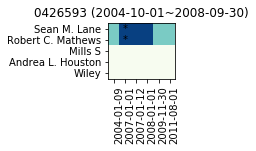

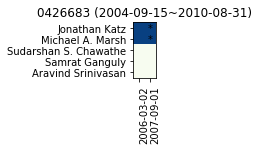

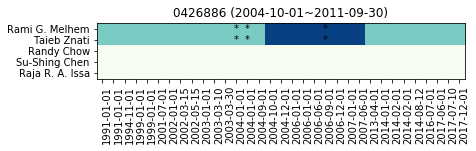

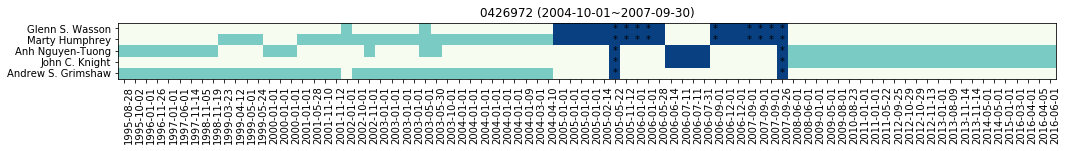

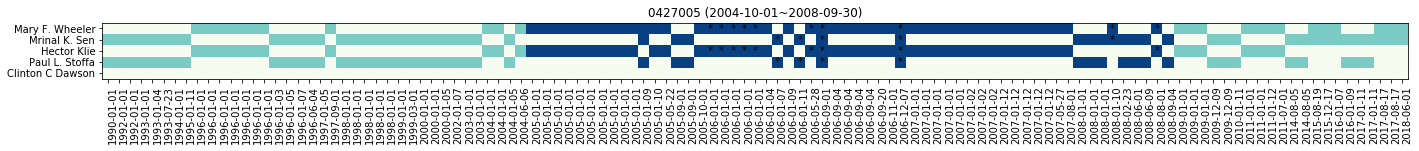

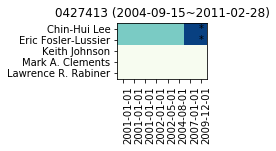

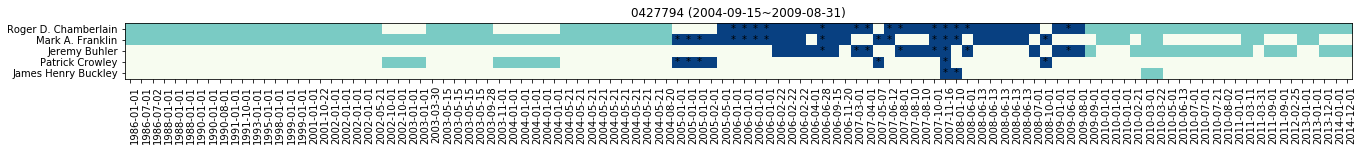

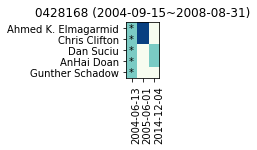

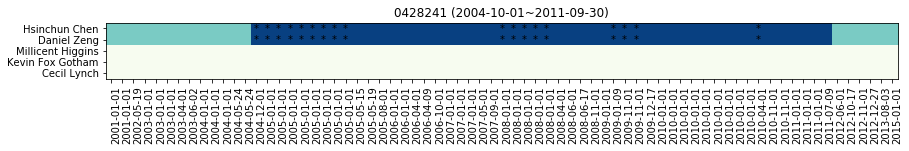

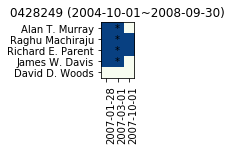

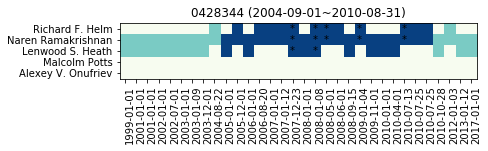

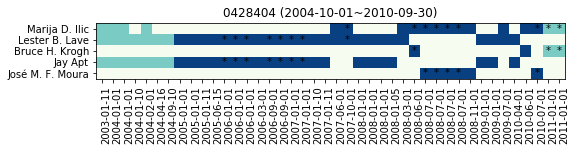

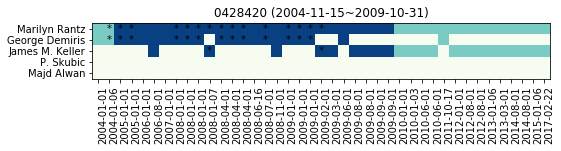

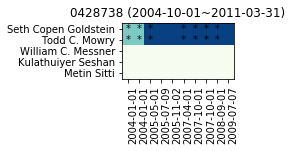

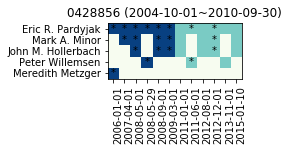

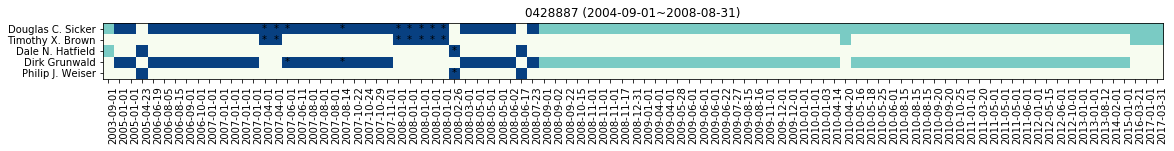

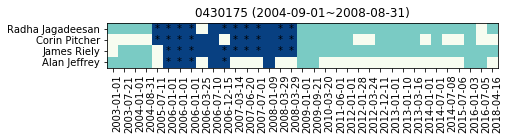

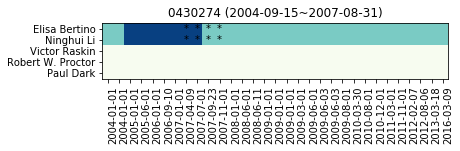

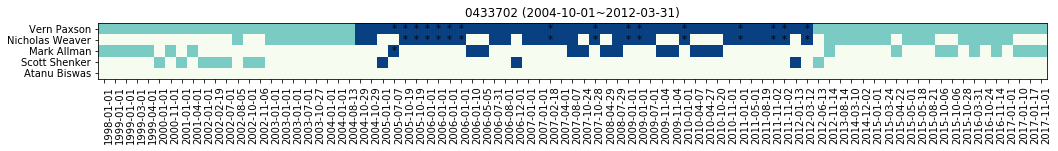

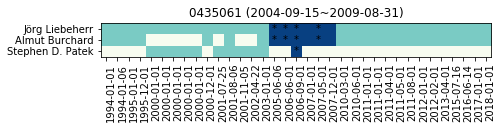

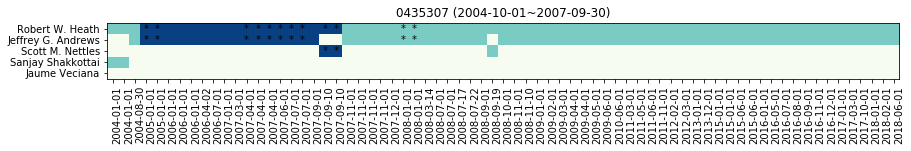

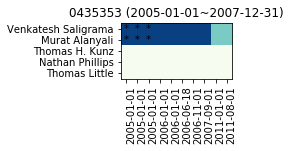

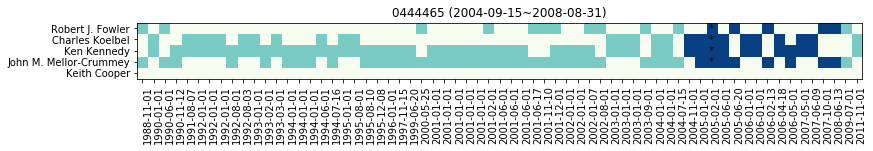

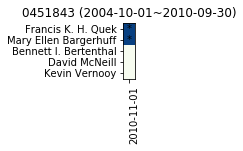

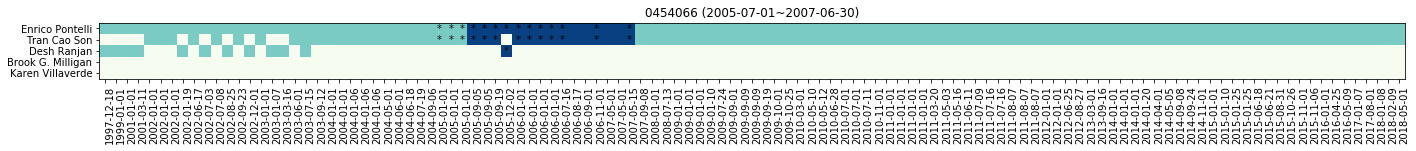

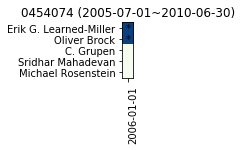

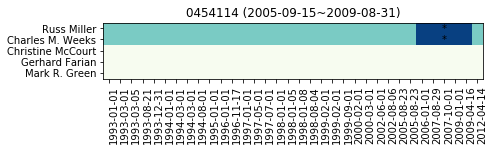

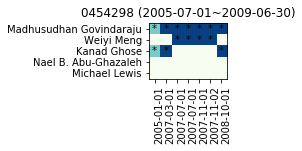

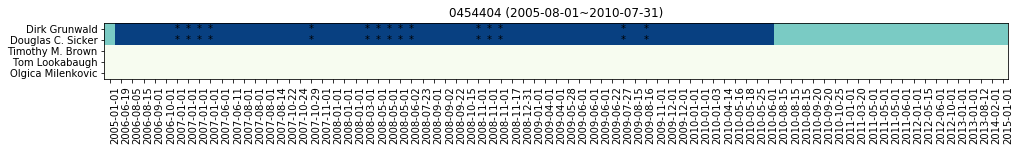

In [87]:
for pid in grant_list:
    plot_coauthor_heatmap_paper(pid)

/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


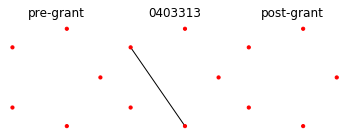

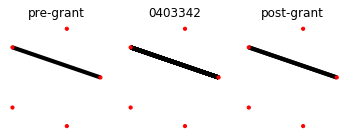

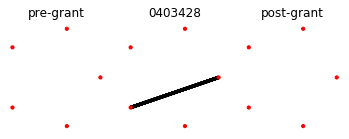

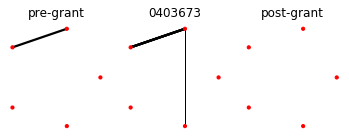

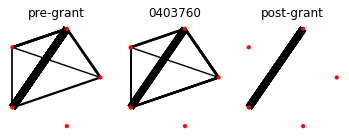

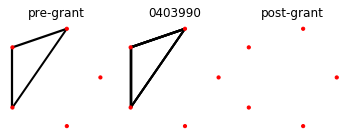

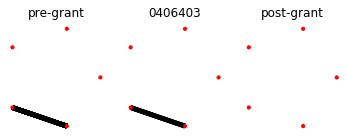

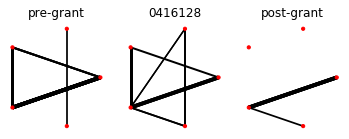

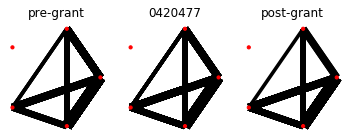

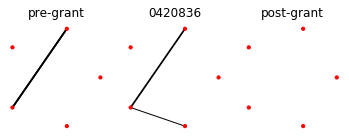

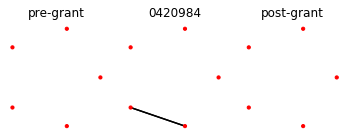

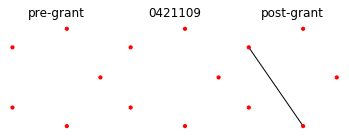

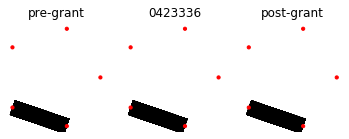

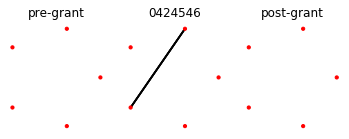

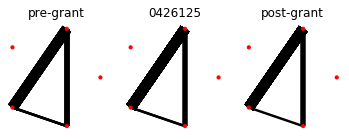

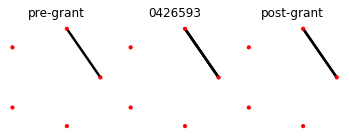

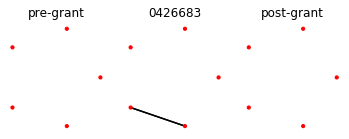

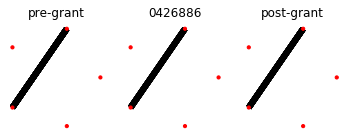

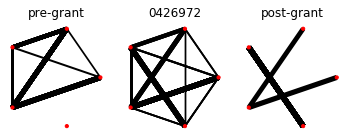

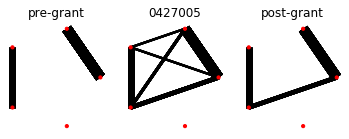

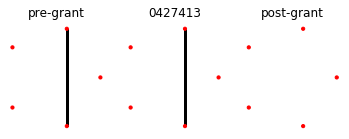

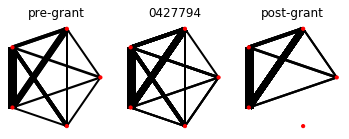

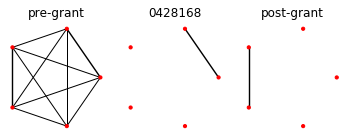

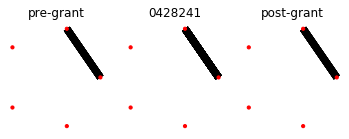

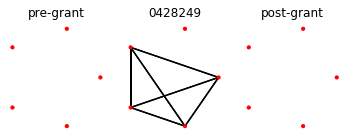

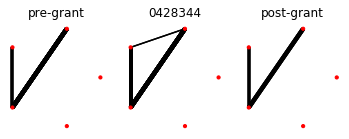

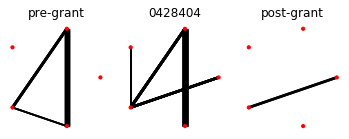

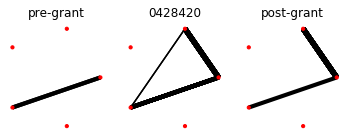

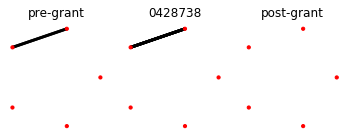

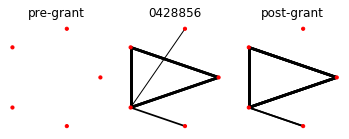

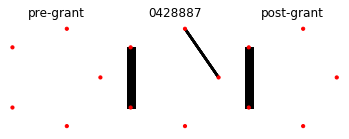

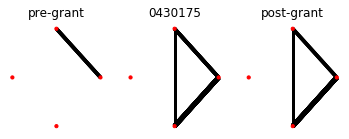

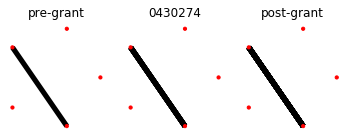

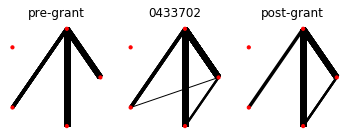

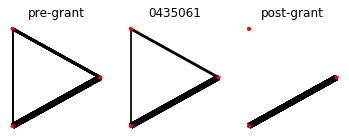

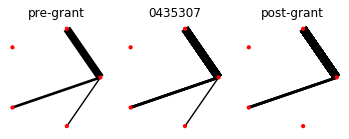

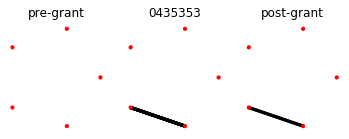

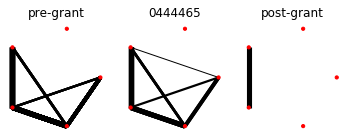

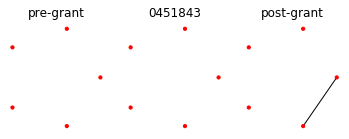

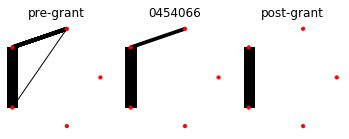

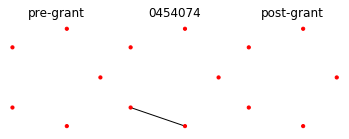

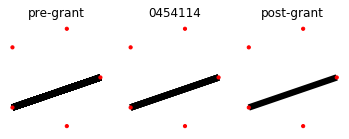

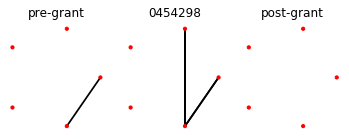

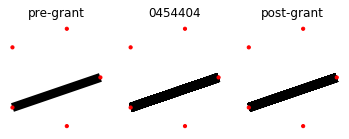

In [23]:
for grant_id in grant_list:
    _,ts,te,G = core.coworknet.get_grant_coworknet_pis(grant_id)
    if len(G.edges) == 0:
        continue
#     print(G.edges.data())
    fig = plt.figure(figsize=(6,2))
    pos = nx.circular_layout(G)
    for idx, nxtype in enumerate(["pre-grant", "grant", "post-grant"]):
        e_colors = []
        n_colors = []
        weight = []
        for v,data in G.nodes.data():
            n_colors.append("red") 
        for u,v,data in G.edges.data():
            if nxtype == "pre-grant":
                e_colors.append("black" if data["date"] < ts else "white")
                weight.append(np.sqrt(len(G[u][v])) if data["date"] < ts else 0)
            if nxtype == "grant":
                e_colors.append("black" if ts <= data["date"] and data["date"] <= te else "white")
                weight.append(np.sqrt(len(G[u][v])) if ts <= data["date"] and data["date"] <= te else 0)
            if nxtype == "post-grant":
                e_colors.append("black" if te < data["date"] else "white")
                weight.append(np.sqrt(len(G[u][v])) if te < data["date"] else 0)
        fig.add_subplot(1,3,1+idx).set_title(grant_id if nxtype == "grant" else nxtype)
        degree = [10 for i in G.nodes()]
        nx.draw(G, pos, node_size=degree, node_color=n_colors, edge_alpha=e_colors, width=weight)

In [7]:
grant_list = [k for k, d in data.items() if d["org"] in div_type.keys() and d["num_pis"] == 2]
print(len(grant_list), "grants with 2 PIs")

243 grants with 2 PIs


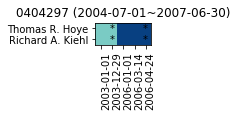

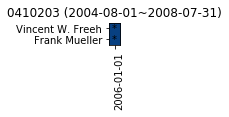

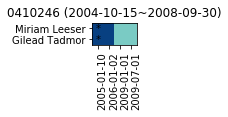

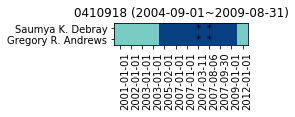

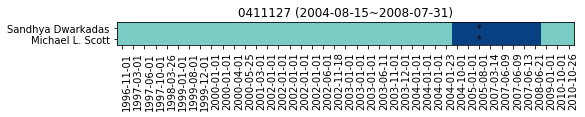

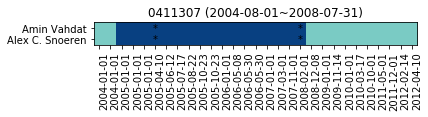

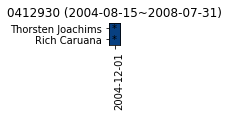

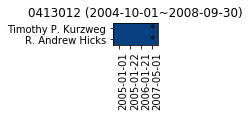

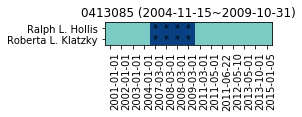

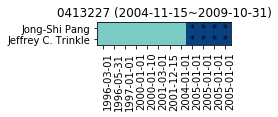

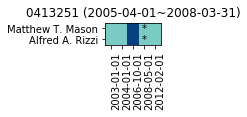

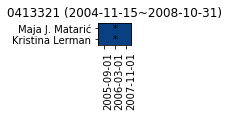

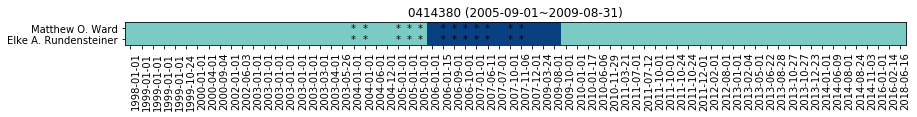

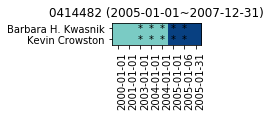

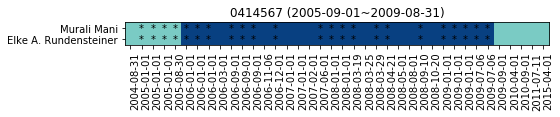

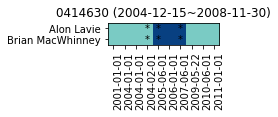

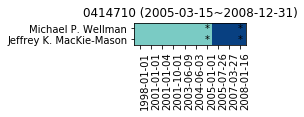

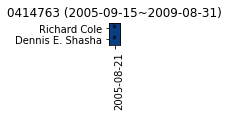

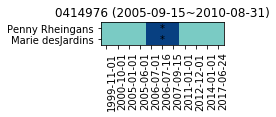

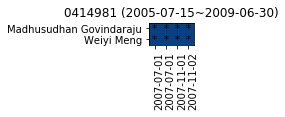

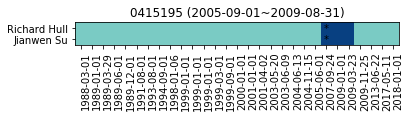

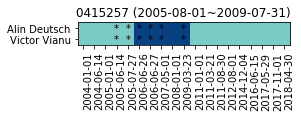

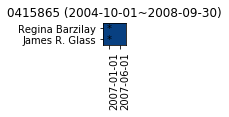

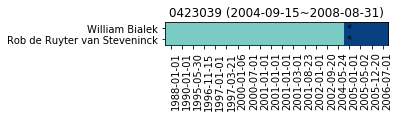

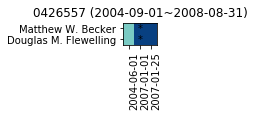

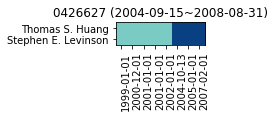

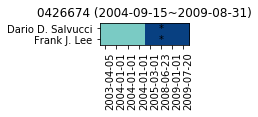

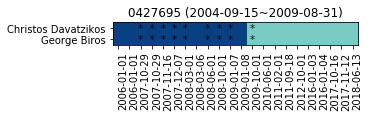

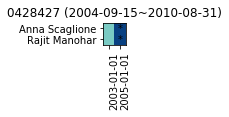

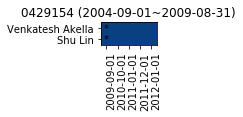

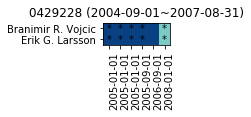

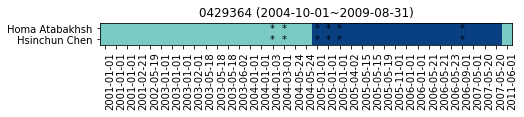

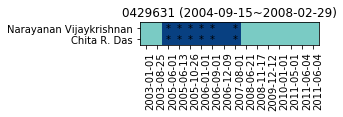

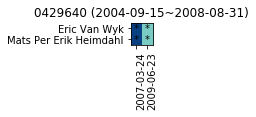

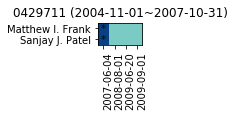

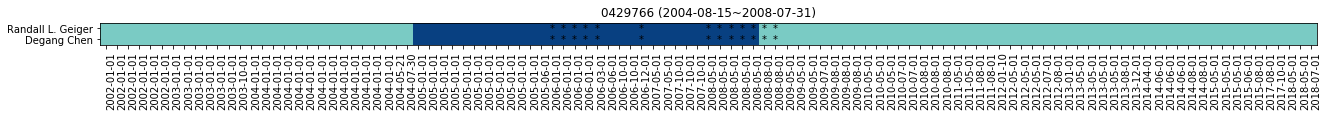

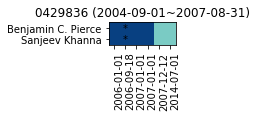

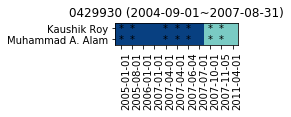

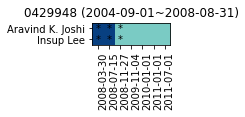

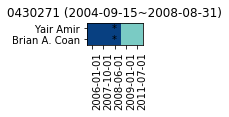

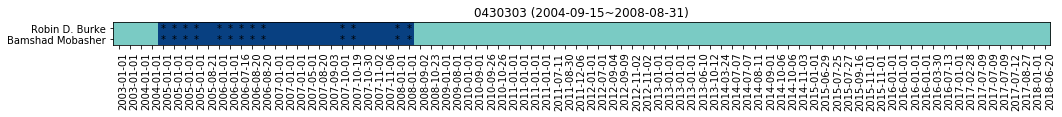

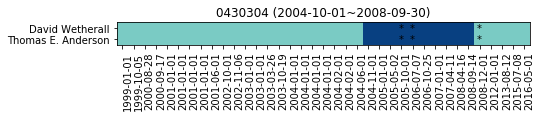

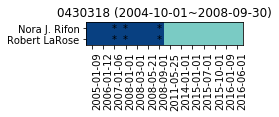

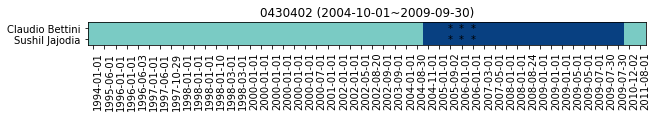

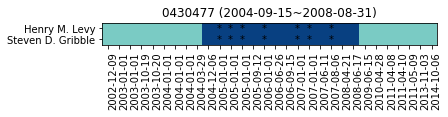

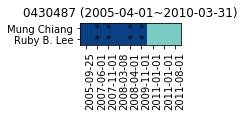

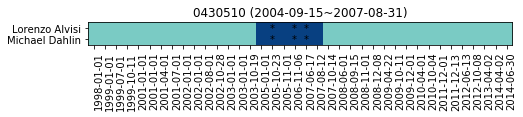

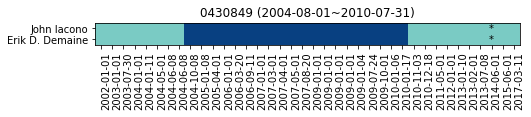

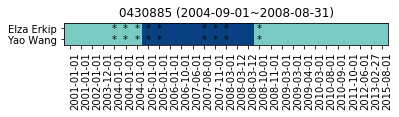

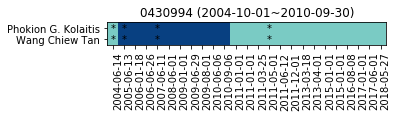

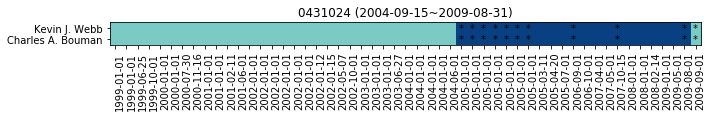

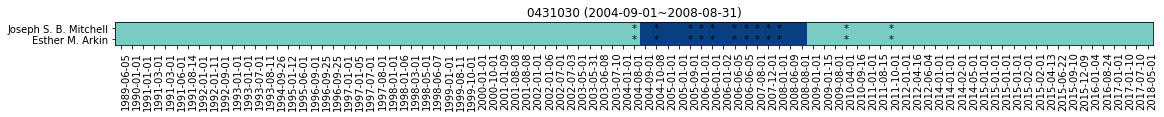

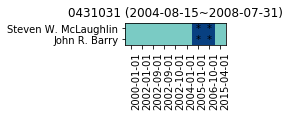

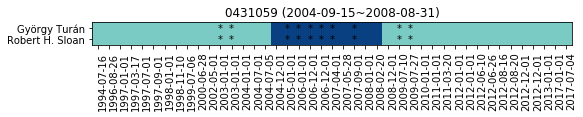

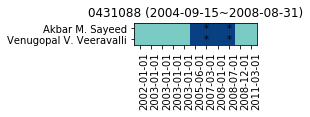

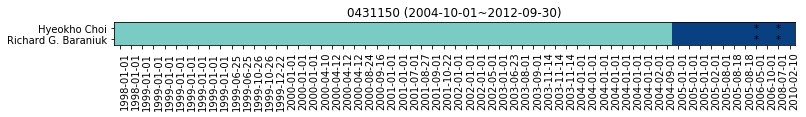

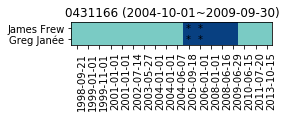

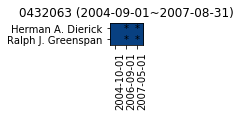

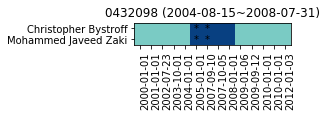

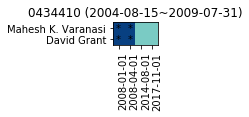

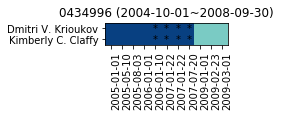

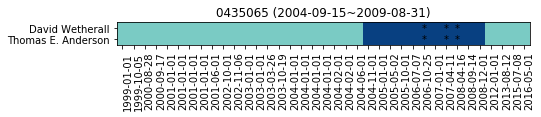

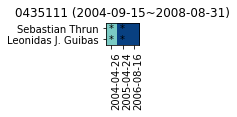

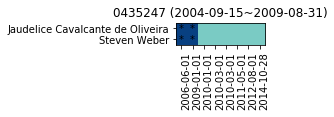

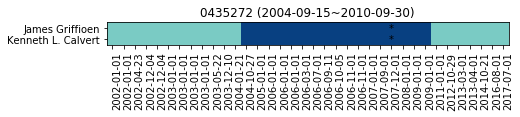

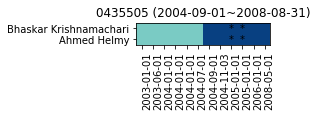

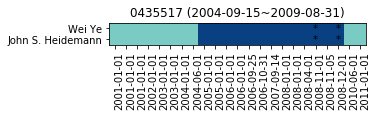

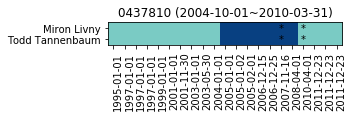

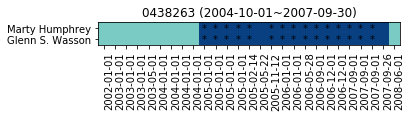

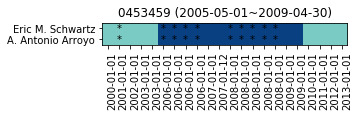

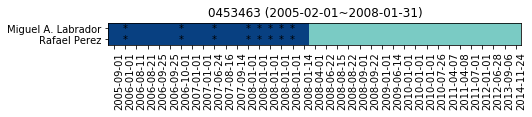

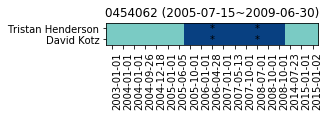

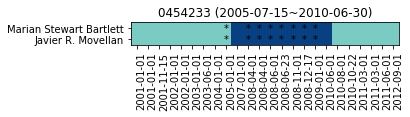

170 grants have no publication between PIs ['0401049', '0403020', '0403130', '0403590', '0404001', '0404193', '0404440', '0406305', '0406345', '0406384', '0410409', '0410524', '0410553', '0410771', '0410790', '0410937', '0411152', '0412029', '0412858', '0412884', '0412894', '0412965', '0413078', '0413138', '0413196', '0413214', '0413284', '0413328', '0413709', '0414409', '0414557', '0414762', '0414791', '0414815', '0415016', '0415021', '0415101', '0415175', '0415923', '0416364', '0418165', '0420337', '0420434', '0420505', '0420866', '0420873', '0420906', '0420985', '0423014', '0423070', '0423253', '0423305', '0423546', '0423584', '0424601', '0426021', '0426879', '0426904', '0427260', '0427385', '0429211', '0429365', '0429454', '0429469', '0429481', '0429535', '0429591', '0429653', '0429743', '0429781', '0430061', '0430063', '0430077', '0430166', '0430228', '0430258', '0430474', '0430593', '0430654', '0430742', '0430781', '0430822', '0430848', '0430853', '0430892', '0430915', '0430954',

In [20]:
no_publications = []
for pid in grant_list:
    plot_coauthor_heatmap_paper(pid)
print("{} grants have no publication between PIs".format(len(no_publications)), no_publications)

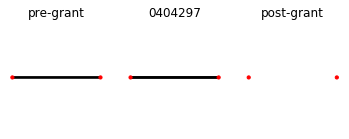

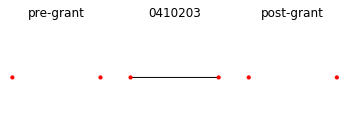

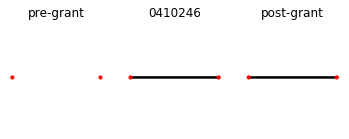

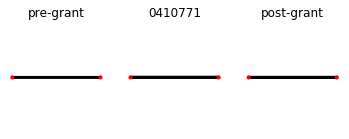

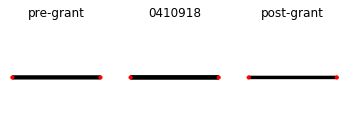

In [33]:
for grant_id in grant_list[:20]:
    _,ts,te,G = core.coworknet.get_grant_coworknet_pis(grant_id)
    if len(G.edges) == 0:
        continue
#     print(G.edges.data())
    fig = plt.figure(figsize=(6,2))
    pos = nx.circular_layout(G)
    for idx, nxtype in enumerate(["pre-grant", "grant", "post-grant"]):
        e_colors = []
        n_colors = []
        weight = []
        for v,data in G.nodes.data():
            n_colors.append("red") 
        for u,v,data in G.edges.data():
            if nxtype == "pre-grant":
                e_colors.append("black" if data["date"] < ts else "white")
                weight.append(np.sqrt(len(G[u][v])) if data["date"] < ts else 0)
            if nxtype == "grant":
                e_colors.append("black" if ts <= data["date"] and data["date"] <= te else "white")
                weight.append(np.sqrt(len(G[u][v])) if ts <= data["date"] and data["date"] <= te else 0)
            if nxtype == "post-grant":
                e_colors.append("black" if te < data["date"] else "white")
                weight.append(np.sqrt(len(G[u][v])) if te < data["date"] else 0)
        fig.add_subplot(1,3,1+idx).set_title(grant_id if nxtype == "grant" else nxtype)
        degree = [10 for i in G.nodes()]
        nx.draw(G, pos, node_size=degree, node_color=n_colors, edge_alpha=e_colors, width=weight)

In [18]:
no_collab = []
collab_type = {}
dict_publications = {}
dict_citations = {}
dict_periods = {}
for grant_id in grant_list:
    _,ts,te,G = core.coworknet.get_grant_coworknet_pis(grant_id)
    if len(G.edges) == 0:
        no_collab.append(grant_id)
        continue
    pos = nx.circular_layout(G)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [data["date"] for _,_,data in G.edges.data()]
    periods = {"pre-grant":max(0, (ts-min(dates)).days), "grant":(te-ts).days, "post-grant":max(0, (max(dates)-te).days)}
    for idx, nxtype in enumerate(["pre-grant", "grant", "post-grant"]):
        for u,v,data in G.edges.data():
            if nxtype == "pre-grant":
                publications[nxtype] += 1 if data["date"] < ts else 0
                citations[nxtype] += data["citation"] if data["date"] < ts else 0
            if nxtype == "grant":
                publications[nxtype] += 1 if ts <= data["date"] and data["date"] <= te else 0
                citations[nxtype] += data["citation"] if ts <= data["date"] and data["date"] <= te else 0
            if nxtype == "post-grant":
                publications[nxtype] += 1 if te < data["date"] else 0
                citations[nxtype] += data["citation"] if te < data["date"] else 0
    print(grant_id, publications.values(), periods.values(), citations.values())
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_periods[grant_id] = periods
    collab_type[grant_id] = "{}{}{}".format(1 if publications["pre-grant"] > 0 else 0, 1 if publications["grant"] > 0 else 0, 1 if publications["post-grant"] > 0 else 0)

0404297 dict_values([2, 3, 0]) dict_values([547, 1094, 0]) dict_values([49, 34, 0])
0410203 dict_values([0, 1, 0]) dict_values([0, 1460, 0]) dict_values([0, 2, 0])
0410246 dict_values([0, 2, 2]) dict_values([0, 1446, 274]) dict_values([0, 20, 5])
0410771 dict_values([1, 5, 3]) dict_values([623, 1446, 954]) dict_values([16, 145, 69])
0410918 dict_values([4, 7, 1]) dict_values([1339, 1825, 853]) dict_values([188, 211, 1])
0411127 dict_values([30, 8, 3]) dict_values([2844, 1446, 817]) dict_values([1493, 391, 41])
0411307 dict_values([2, 17, 10]) dict_values([213, 1460, 1349]) dict_values([178, 783, 664])
0412930 dict_values([0, 1, 0]) dict_values([0, 1446, 0]) dict_values([0, 24, 0])
0413012 dict_values([0, 4, 0]) dict_values([0, 1460, 0]) dict_values([0, 11, 0])
0413085 dict_values([4, 4, 7]) dict_values([1414, 1811, 2008]) dict_values([72, 60, 66])
0413227 dict_values([8, 4, 0]) dict_values([3181, 1811, 0]) dict_values([320, 19, 0])
0413251 dict_values([2, 1, 2]) dict_values([821, 1095,

In [19]:
Counter(collab_type.values())

Counter({'110': 11, '010': 8, '011': 14, '111': 36, '100': 1, '001': 1})

In [20]:
print("total {} grant with 2PIs - never collaborated '000': {}".format(len(grant_list), len(no_collab)))

total 243 grant with 2PIs - never collaborated '000': 172


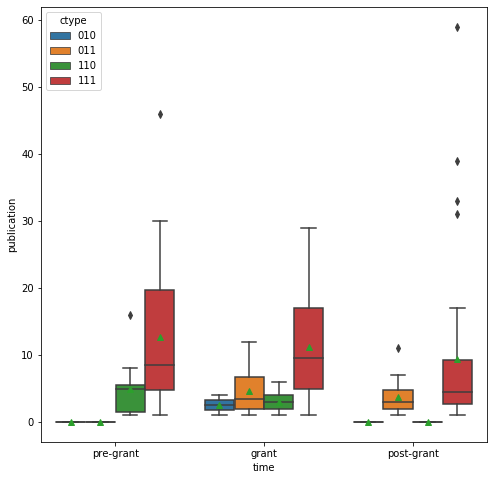

In [26]:
x = ["pre-grant", "grant", "post-grant"]
ctype = ['010', '110', '011', '111']
box_plot_data = pd.DataFrame({
    "time": [time for time in x for k, v in collab_type.items() if v in ctype],
    "period": [dict_periods[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "publication": [dict_publications[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "citation": [dict_citations[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "ctype": [v for time in x for k, v in collab_type.items() if v in ctype]
})
        
# print(box_plot_data.head(5))
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="publication", hue="ctype", data=box_plot_data, showmeans=True)

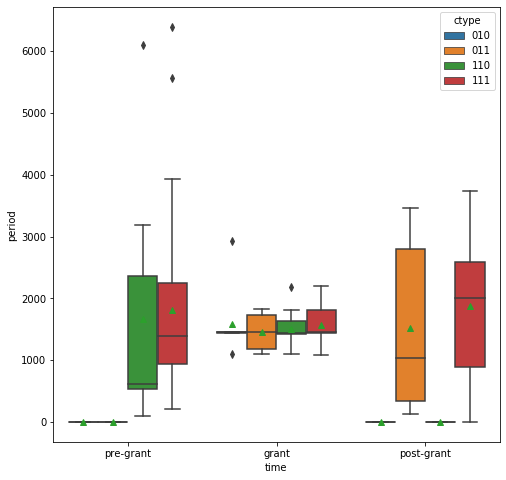

In [27]:
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="period", hue="ctype", data=box_plot_data, showmeans=True)

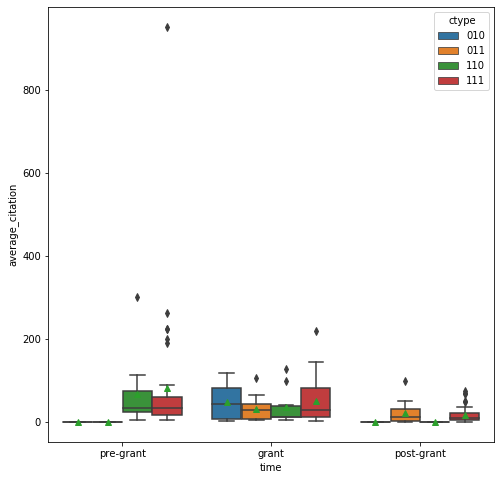

In [28]:
box_plot_data["average_citation"] = (box_plot_data["citation"]/box_plot_data["publication"]).fillna(0)
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="average_citation", hue="ctype", data=box_plot_data, showmeans=True)

In [29]:
data = {}
years = [2009]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"] == code and v["year"] == y]))

[2009]
Total number of grants 14758
Division of Computer and Network Systems (CNS) 733
Division of Computing and Communication Foundations (CCF) 535
Division of Information and Intelligent Systems (IIS) 627
Office of Advanced Cyberinfrastructure (OAC) 193


Counter({1: 1258, 2: 457, 3: 174, 5: 93, 4: 83, 6: 15, 7: 4, 8: 2, 0: 2})


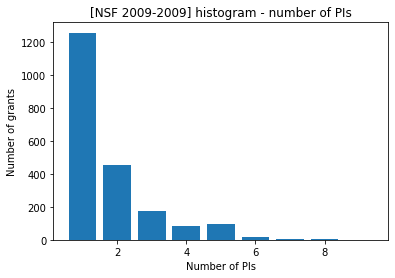

In [30]:
histogram_num_pis(data, years, div_type.keys())

In [31]:
grant_list = [k for k, d in data.items() if d["org"] in div_type.keys() and d["num_pis"] == 2]
print(len(grant_list), "grants with 2 PIs")

457 grants with 2 PIs
